In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import trace_file_processor as tfp


In [2]:


#Delay factor is the delay in seconds for the receiver to observe data after trace experiment has begun
#This was derived experimentally from Pantheon - should double check exact value since it is an approx. right now
DELAY_FACTOR = 3.128

In [3]:

def plot_trace(rate, time):
    
    plt.figure(figsize=(7,5))
    plt.fill_between(time[0:58], 0, rate[1:58], facecolor='green')
    plt.show()

    
def read_data(filename):
    
    import csv
    
    data : list

    with open(filename, newline='') as csvfile:
        
        data = list(csv.reader(csvfile))
        
    return np.array([float(x[0]) for x in data])


def pre_process_data(data):
    
    for i in range(0, len(data)):
        
        if (data[i] == float("nan")):
            
            data[i] = 0
    
    return data


def check_data_length(data):
    
    trace_length = len(data[1:]) * data[0] #in ms
    return trace_length

def pad_data_with_starting_delay(data):
    
    TICK_TIME = data[0] / 1000
    
    #Number of pre-pends before we actually observe data
    iterations = int(DELAY_FACTOR / TICK_TIME)
    
    #Drop the tick time indicator at the start
    data = data[1:]
        
    for i in range (0, iterations):
        
        #Pre-pend with zeros as no data observed
        data = np.concatenate(([0], data))
    
    #Add the tick time indicator back
    data = np.concatenate(([TICK_TIME*1000], data))
    
    return data


#Ensure length of trace corresponds to length of data (to ensure consistent plotting)

def get_corresponding_trace_length(trace, data):
    
    TICK_TIME = data[0] / 1000
    
    data_length = check_data_length(data) / 1000
    
    trace_index = (1/TICK_TIME) * data_length
    
    #Ensure we add additional datapoints introduced for the delay of the data collection
    trace_index = trace_index + int(DELAY_FACTOR / TICK_TIME)
    
    return int(trace_index)

def plot_data(data):
    
    TICK_TIME = data[0] / 1000
    
    x_coord = np.array([(TICK_TIME)*(i+1) for i in np.arange(len(data[1:]))])
    y_coord = data[1:]
    
    plt.fill_between(x_coord, 0, y_coord, facecolor='blue')
    plt.show()

"""

This takes an arbitrary number of lists of data
and plots them all on subplots to allow for
comparison

NOTE: The first argument has to be the true link capacity as otherwise
      the results will not be shifted correct in time

"""
def plot_all(*argv):
    
    TICK_TIME = argv[0][0] / 1000 #First entry in data sets is the tick time in ms
    CAPACITY_TRACE_INDEX = 0
    
    data_sets = len(argv)
    
    ROWS = data_sets + 1 #+1 for the superposing
    COLUMNS = 1
    
    fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(8, 25))
    
    #fig.suptitle('Shows the trace and the corresponding congestion control metrics')
    
    color_list = ['pink', 'purple', 'blue', 'olive', 'cyan', 'red', 'orange', 'brown', 'gray']
    
    data = argv[CAPACITY_TRACE_INDEX]
    
    #IMPORTANT: argv argument (in this case argv[2]) should be the shortest array of data to ensure correct overlap when plotting
    trace_plot_length = get_corresponding_trace_length(argv[CAPACITY_TRACE_INDEX], argv[1])
    
    titles = ["Channel Bandwidth", "Throughput", "RTT Gradient", "Queueing Delay", "Inter Arrival Time"]
    y_labels = ["Throughput (Mbit/s)", "Throughput (Mbit/s)", "RTT Gradient (Dimensionless)", "Queuing Delay (s)", "Inter Arrival Time (s)", "Throughput (Mbit/s)"]
    
    for i in range(0, len(argv)):
        
        if (not (i == CAPACITY_TRACE_INDEX)):
            
            data = pad_data_with_starting_delay(argv[i])[1:trace_plot_length] #Drop tick time indicator
            plot_length = len(data[1:trace_plot_length]) + 1    # +1 to ensure we match the last element
            #print("NON-TRACE")
            #print(len(data))
            #print(plot_length)            
        
        else:
            
            data = argv[i][1:trace_plot_length]
            plot_length = trace_plot_length - 1 # -1 to ensure we do not add additional datapoint
            
            #print("TRACE")
            #print(len(data))
            #print(plot_length)
            
        x_coord = np.array([(TICK_TIME)*(k+1) for k in np.arange(plot_length)])
        axs[i].fill_between(x_coord, 0, data, facecolor=color_list[i])
        #axs[i].scatter(x_coord, data, color=color_list[i])
        
        axs[i].set_title(titles[i], pad=20, fontsize=14)
        axs[i].set_xlabel("Time (s)", fontsize=12)
        axs[i].set_ylabel(y_labels[i], fontsize=12)
        
        #axs[i].savefig(titles[i] + ".png")
    
    data_cap = argv[CAPACITY_TRACE_INDEX][1:trace_plot_length]
    data_thr = pad_data_with_starting_delay(argv[1])[1:trace_plot_length]
    
    axs[ROWS - 1].fill_between(x_coord, 0, data_cap, facecolor=color_list[CAPACITY_TRACE_INDEX])
    axs[ROWS - 1].fill_between(x_coord, 0, data_thr, facecolor=color_list[1])
    axs[ROWS - 1].set_xlabel("Time (s)", fontsize=12)
    axs[ROWS - 1].set_ylabel(y_labels[ROWS - 1])
    
    #Label properly
    
    fig.tight_layout(pad=2.0)
    
    #fig.savefig('sample_output.png', bbox_inches='tight', dpi=1000)
    

In [4]:
trace_name = 'TMobile-UMTS'

TICK_TIME = 60

#Load the trace data
rate, time = tfp.process_trace('traces/' + trace_name + '-driving.up', TICK_TIME)


#Adding tick time indicator for the rate - should probably add at an earlier stage
rate = np.concatenate(([TICK_TIME], rate))

In [46]:

path = 'TRAIN-DATA/'

rtt_grad_data = read_data(path + trace_name + '/rtt_grad_data_run_1.csv')
throughput = read_data(path + trace_name + '/throughput_data_run_1.csv')

queue_delay = read_data(path + trace_name + '/queue_delay_data_run_1.csv')
inter_arrival = read_data(path + trace_name + '/inter_arrival_data_run_1.csv')



ValueError: operands could not be broadcast together with shapes (280023,) (15510,) 

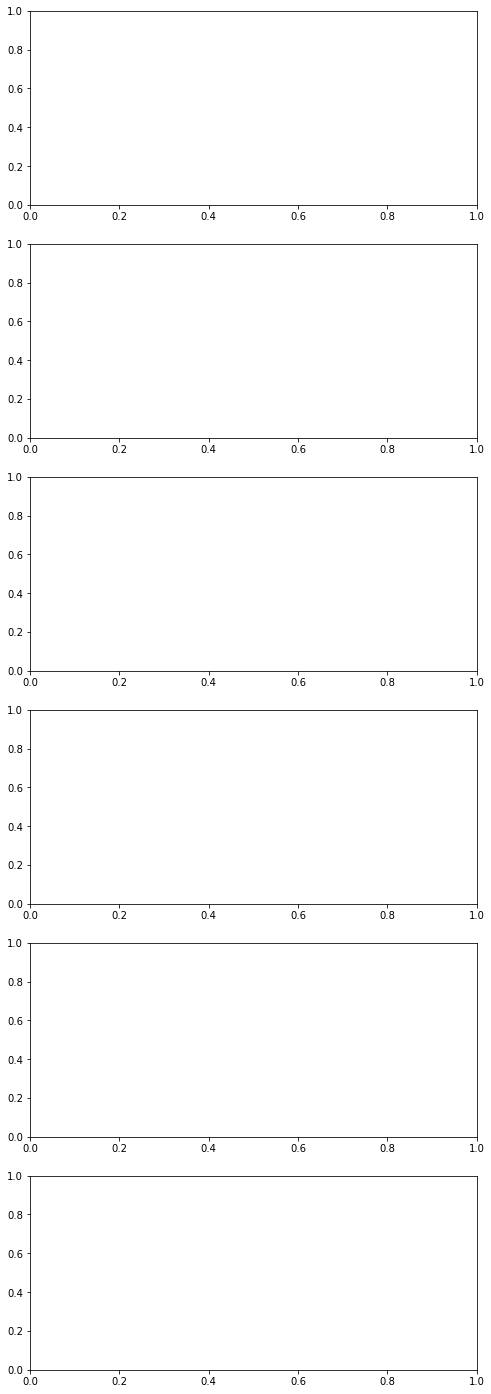

In [47]:
check_data_length(rate)

plot_all(rate, throughput, rtt_grad_data, queue_delay, inter_arrival)
#plot_data(rtt_grad_data_1)


In [ ]:
throughput = read_data('Sprout-RMSE/sprout-throughput-Verizon-LTE.csv')

In [ ]:

def save_all(*argv):
    
    TICK_TIME = argv[0][0] / 1000 #First entry in data sets is the tick time in ms
    CAPACITY_TRACE_INDEX = 0
    
    data_sets = len(argv)
    
    ROWS = data_sets + 1 #+1 for the superposing
    COLUMNS = 1
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    
    #fig.suptitle('Shows the trace and the corresponding congestion control metrics')
    
    color_list = ['pink', 'purple', 'blue', 'olive', 'cyan', 'red', 'orange', 'brown', 'gray']
    
    data = argv[CAPACITY_TRACE_INDEX]
    
    #IMPORTANT: argv argument (in this case argv[2]) should be the shortest array of data to ensure correct overlap when plotting
    trace_plot_length = get_corresponding_trace_length(argv[CAPACITY_TRACE_INDEX], argv[2])
    
    titles = ["Channel Bandwidth", "Throughput", "RTT Gradient", "Queueing Delay", "Inter Arrival Time"]
    y_labels = ["Throughput (Mbit/s)", "Throughput (Mbit/s)", "RTT Gradient (Dimensionless)", "Queuing Delay (s)", "Inter Arrival Time (s)", "Throughput (Mbit/s)"]
    
    for i in range(0, len(argv)):
        
        if (not (i == CAPACITY_TRACE_INDEX)):
            
            data = pad_data_with_starting_delay(argv[i])[1:trace_plot_length] #Drop tick time indicator
            plot_length = len(data[1:trace_plot_length]) + 1    # +1 to ensure we match the last element
            #print("NON-TRACE")
            #print(len(data))
            #print(plot_length)            
        
        else:
            
            data = argv[i][1:trace_plot_length]
            plot_length = trace_plot_length - 1 # -1 to ensure we do not add additional datapoint
            
            #print("TRACE")
            #print(len(data))
            #print(plot_length)
            
        x_coord = np.array([(TICK_TIME)*(k+1) for k in np.arange(plot_length)])
        
        if (i == 0 ):
            
            axs[0][0].fill_between(x_coord, 0, data, facecolor=color_list[i])
            #axs[i].scatter(x_coord, data, color=color_list[i])
        
            axs[0][0].set_title(titles[i], pad=20, fontsize=14)
            axs[0][0].set_xlabel("Time (s)", fontsize=12)
            axs[0][0].set_ylabel(y_labels[i], fontsize=12)
            
        elif i == 2:
            
            axs[0][1].fill_between(x_coord, 0, data, facecolor=color_list[i])
            #axs[i].scatter(x_coord, data, color=color_list[i])
        
            axs[0][1].set_title(titles[i], pad=20, fontsize=14)
            axs[0][1].set_xlabel("Time (s)", fontsize=12)
            axs[0][1].set_ylabel(y_labels[i], fontsize=12)
        
        elif i == 3:
            
            axs[1][0].fill_between(x_coord, 0, data, facecolor=color_list[i])
            #axs[i].scatter(x_coord, data, color=color_list[i])
        
            axs[1][0].set_title(titles[i], pad=20, fontsize=14)
            axs[1][0].set_xlabel("Time (s)", fontsize=12)
            axs[1][0].set_ylabel(y_labels[i], fontsize=12)
        
        elif i == 4:
            
            axs[1][1].fill_between(x_coord, 0, data, facecolor=color_list[i])
            #axs[i].scatter(x_coord, data, color=color_list[i])
        
            axs[1][1].set_title(titles[i], pad=20, fontsize=14)
            axs[1][1].set_xlabel("Time (s)", fontsize=12)
            axs[1][1].set_ylabel(y_labels[i], fontsize=12)
            
        
        #axs[i].savefig(titles[i] + ".png")
    
    #data_cap = argv[CAPACITY_TRACE_INDEX][1:trace_plot_length]
    #data_thr = pad_data_with_starting_delay(argv[1])[1:trace_plot_length]
    
    #axs[ROWS - 1].fill_between(x_coord, 0, data_cap, facecolor=color_list[CAPACITY_TRACE_INDEX])
    #axs[ROWS - 1].fill_between(x_coord, 0, data_thr, facecolor=color_list[1])
    #axs[ROWS - 1].set_xlabel("Time (s)", fontsize=12)
    #axs[ROWS - 1].set_ylabel(y_labels[ROWS - 1])
    
    #Label properly
    
    fig.tight_layout(pad=2.0)
    
    fig.savefig('sample_output.png', bbox_inches='tight', dpi=1000)
    

In [ ]:

#rtt_grad_data = read_data('rtt_grad_data_run_2.csv')
#throughput = read_data('throughput_data_run_2.csv')

#queue_delay = read_data('queue_delay_data_run_2.csv')
#inter_arrival = read_data('inter_arrival_data_run_2.csv')

plot_all(rate, throughput)

print(throughput[:10])
print(rate[:10])

rmse = np.sqrt(np.mean((throughput - rate[:len(throughput)])**2))

print(rmse)

In [ ]:
check_data_length(throughput)

In [ ]:

plot_all(rate, rtt_grad_data_2, throughput_2)


In [ ]:
plot_all(rate, rtt_grad_data_3, throughput_3)

In [ ]:
plot_all(rate, rtt_grad_data_4, throughput_4)

In [ ]:
plot_all(rate, rtt_grad_data_5, throughput_5)

In [ ]:

rtt_grad_data = read_data('rtt_grad_data_test.csv')
through = read_data('throughput_data_test.csv')

plot_all(rate, rtt_grad_data, through)


In [ ]:

rtt_grad_data = read_data('rtt_grad_data_test_2.csv')
through = read_data('throughput_data_test_2.csv')

plot_all(rate, rtt_grad_data, through)


In [ ]:

rtt_grad_data = read_data('rtt_grad_data_test_3.csv')
through = read_data('throughput_data_test_3.csv')

plot_all(rate, rtt_grad_data, through)

In [ ]:

rtt_grad_data = read_data('rtt_grad_data_test_4.csv')
through = read_data('throughput_data_test_4.csv')

plot_all(rate, rtt_grad_data, through)

In [ ]:

rtt_grad_data = read_data('rtt_grad_data_test_5.csv')
through = read_data('throughput_data_test_5.csv')

plot_all(rate, rtt_grad_data, through)

In [ ]:

#Check that length is roughly correct
trace_length = len(rtt_grad_data) * TICK_TIME #in sec

#This will be less than the true length as processing time takes a lot of time
print("Trace Length: {} ".format(trace_length))

In [ ]:
#Plot the RTT Gradients versus time

#We start at time 20ms - i+1
x_coord = np.array([(TICK_TIME)*(i+1) for i in np.arange(len(rtt_grad_data))])
y_coord = rtt_grad_data

In [ ]:
#plt.scatter(x_coord, y_coord)
plt.fill_between(x_coord, 0, y_coord, facecolor='blue')

plt.show()

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].fill_between(time[0:58], 0, rate[0:58], facecolor='green')
axs[1].fill_between(x_coord, 0, y_coord, facecolor='blue')

In [ ]:
import math



In [ ]:
math.isnan(float("nan"))

In [ ]:
i == float("nan")